# **Importando librerias necesarias**

**Para deshabilitar wandb.ai del modelo BERT, si tiene cuenta de wandb.ai puede no ejecutar esta celda e insertar la API-Key cuando se pide en el entrenamiento y ver las metricas en dicha pagina , de lo contrario siempre ejecutar**

In [1]:
import os
os.environ["WANDB_MODE"] = "disabled"

In [2]:
!pip install tensorflow==2.16.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 88.9 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.1
    Uninstalling tensorboard-2.15.1:
      Successfully uninstalled tensorboard-2.15.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
ten

In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.stem.snowball import SnowballStemmer
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import re

# **Cargando Datos del Dataset y Preprocesando el mismo (no es lo mismo que preprocesar el texto ojo)**

In [4]:
df = pd.read_csv('/kaggle/input/emotions/text.csv')
df.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


In [5]:
print(f'Dimension de los datos : {df.shape}') #(Filas,Columnas)

Dimension de los datos : (416809, 3)


In [6]:
df.duplicated().sum() #Comprobando las filas duplicadas

0

In [7]:
df.isnull().sum() #Comprobando las vacias

Unnamed: 0    0
text          0
label         0
dtype: int64

In [8]:
#Renombrando columnas para mayor legibilidad (inplance hace que no te devuelva un dataframe y guarde todo en el mismo dataframe)
df.rename(columns={'text': 'Text', 'label': 'Label'}, inplace=True)

In [9]:
#Eliminando la columna Unnamed , aparece en los csv donde hay un indice sin nombre
#axis 1 elimina columna , axis 0 una fila
df.drop('Unnamed: 0',axis=1,inplace=True)

In [10]:
#Visualizando cambios 
df.head()

,Text,Label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


In [11]:
#Renombrando las columnas a las emociones (ingles es el idioma del dataset)
#0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'
df['Label'] = df['Label'].replace(0,'Sadness')
df['Label'] = df['Label'].replace(1,'Joy')
df['Label'] = df['Label'].replace(2,'Love')
df['Label'] = df['Label'].replace(3,'Anger')
df['Label'] = df['Label'].replace(4,'Fear')
df['Label'] = df['Label'].replace(5,'Surprise')

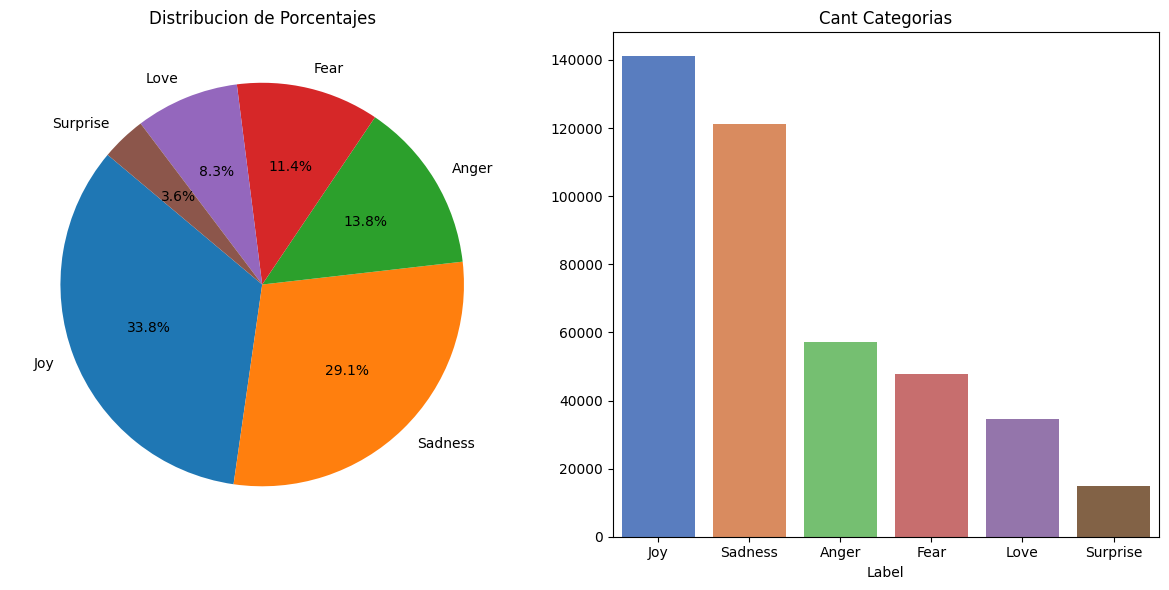

In [12]:
#Visualizando graficos para entender mejor el dataset

# Sumando la cant de cada categoria
count = df['Label'].value_counts()

# Creando figura con dos graficos 
fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')

# Grafico de Pastel
palette = sns.color_palette("muted")
sns.set_palette(palette)
axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Distribucion de Porcentajes')

# Grafico de Barras
sns.barplot(x=count.index, y=count.values, ax=axs[1], palette="muted")
axs[1].set_title('Cant Categorias')

plt.tight_layout()

plt.show()

# Analizando los datos del DataSet

In [13]:
# Separando cada emocion en un dataframe 

df_sadness = df[df['Label']=='Sadness']
df_joy = df[df['Label']=='Joy']
df_love = df[df['Label']=='Love']
df_anger = df[df['Label']=='Anger']
df_fear = df[df['Label']=='Fear']
df_surprise = df[df['Label']=='Surprise']

**Word Cloud representa visualmente las palabras que tiene cada conjunto , las que mas se repiten se ven mas grandes**...............
**Consume recursos y ralentiza un poco sin aceleracion por GPU**

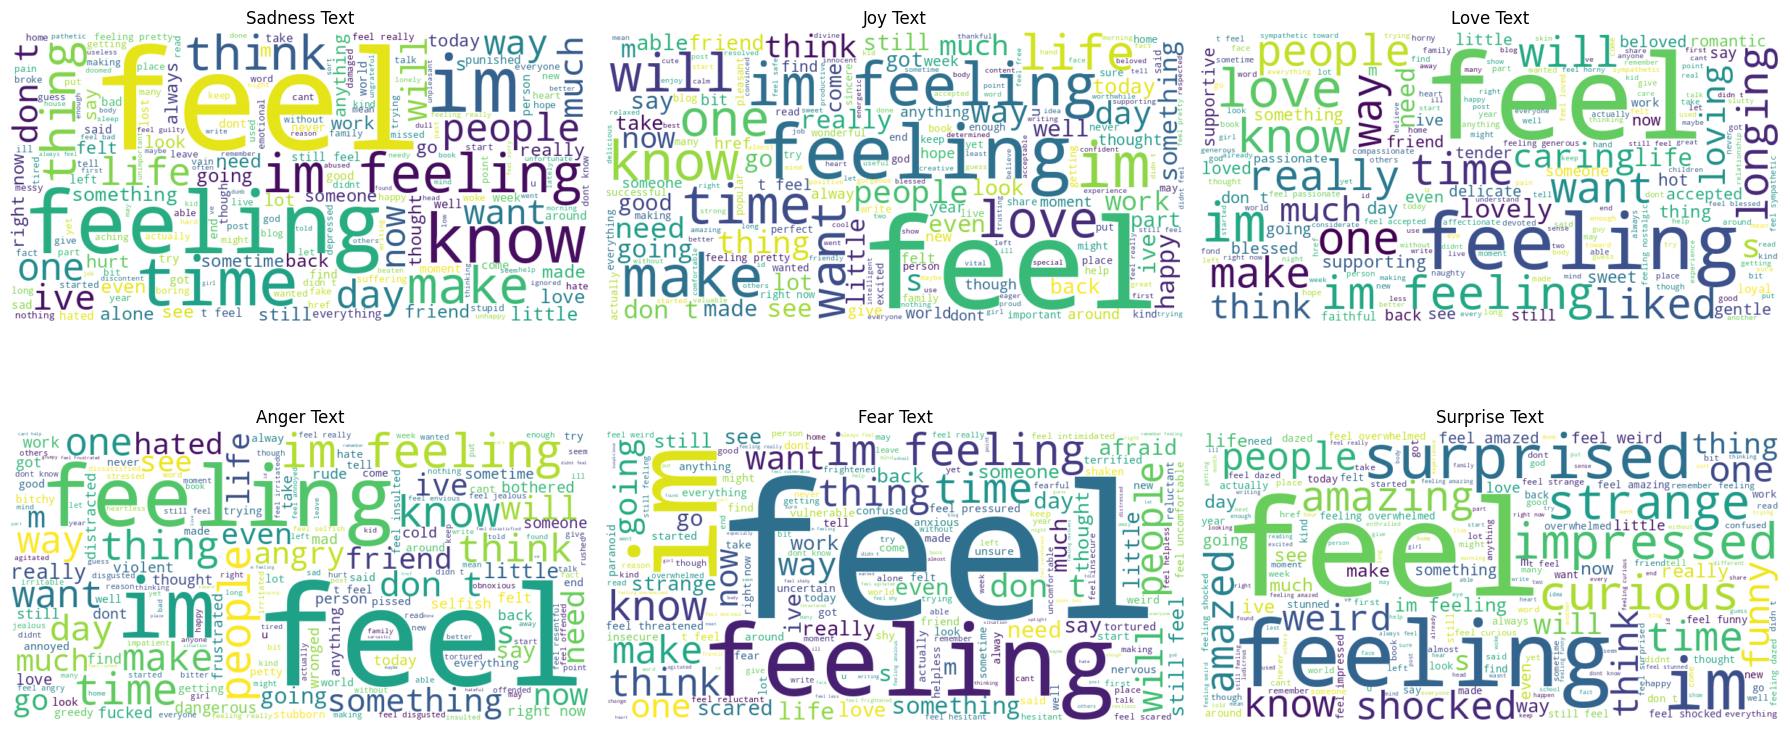

In [14]:
#Combina el texto de cada subconjunto del df en una sola cadena para cada emoción.
combined_sadness_text = ' '.join(df_sadness['Text'])
combined_joy_text = ' '.join(df_joy['Text'])
combined_love_text = ' '.join(df_love['Text'])
combined_anger_text = ' '.join(df_anger['Text'])
combined_fear_text = ' '.join(df_fear['Text'])
combined_surprise_text = ' '.join(df_surprise['Text'])

#Creando las nubes de palabras de cada emocion
sadness_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_sadness_text)
joy_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_joy_text)
love_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_love_text)
anger_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_anger_text)
fear_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_fear_text)
surprise_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_surprise_text)

plt.figure(figsize=(18, 9))

plt.subplot(2, 3, 1)
plt.imshow(sadness_wordcloud, interpolation='bilinear')
plt.title('Sadness Text')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(joy_wordcloud, interpolation='bilinear')
plt.title('Joy Text')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(love_wordcloud, interpolation='bilinear')
plt.title('Love Text')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(anger_wordcloud, interpolation='bilinear')
plt.title('Anger Text')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(fear_wordcloud, interpolation='bilinear')
plt.title('Fear Text')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(surprise_wordcloud, interpolation='bilinear')
plt.title('Surprise Text')
plt.axis('off')

plt.tight_layout()
plt.show()

In [15]:
#Convirtiendo las etiquetas de Text a su valor original para el ML
df['Label'] = df['Label'].replace('Sadness',0)
df['Label'] = df['Label'].replace('Joy',1)
df['Label'] = df['Label'].replace('Love',2)
df['Label'] = df['Label'].replace('Anger',3)
df['Label'] = df['Label'].replace('Fear',4)
df['Label'] = df['Label'].replace('Surprise',5)

/tmp/ipykernel_24/2935977798.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Label'] = df['Label'].replace('Surprise',5)


# **Preprocesamiento de Texto**

**Orden del proceso**

**Paso 1: Eliminar URLs:** Utiliza una expresión regular para eliminar las URLs de los datos de texto.

**Paso 2: Eliminar caracteres especiales y puntuación:** Utiliza una expresión regular para eliminar cualquier carácter especial y signos de puntuación del texto.

**Paso 3: Eliminar espacios en blanco adicionales:** Utiliza una expresión regular para eliminar espacios en blanco adicionales y reemplazarlos por un solo espacio.

**Paso 4: Eliminar valores numéricos:** Utiliza una expresión regular para eliminar cualquier valor numérico del texto.

**Paso 5: Convertir a minúsculas:** Convierte todo el texto a minúsculas para garantizar la consistencia.

**Paso 6: Eliminar palabras vacías:** Elimina las palabras vacías comunes en inglés, como "el," "es," "y," etc., utilizando la lista de palabras vacías de NLTK.

**Paso 7: Eliminar caracteres no alfanuméricos:** Utiliza una expresión regular para eliminar cualquier carácter no alfanumérico del texto

In [16]:
# Importando librerias basicas, nltk --> natural language tool kit
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Descargando Recursos necesarios
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

**REMOVIENDO URL**

In [17]:
#Despues del http se pone \s+ para que tambien reemplace los caracteres no espaciales que van seguidos
df['Text'] = df['Text'].str.replace(r'http\S+', '', regex=True)

print(df.head())

                                                Text  Label
0      i just feel really helpless and heavy hearted      4
1  ive enjoyed being able to slouch about relax a...      0
2  i gave up my internship with the dmrg and am f...      4
3                         i dont know i feel so lost      0
4  i am a kindergarten teacher and i am thoroughl...      4


**REMOVIENDO LOS CARACTERES ESPECIALES Y LOS SIGNOS DE PUNTUACION**

In [18]:
df['Text'] = df['Text'].str.replace(r'[^\w\s]', '', regex=True)

print(df.head())

                                                Text  Label
0      i just feel really helpless and heavy hearted      4
1  ive enjoyed being able to slouch about relax a...      0
2  i gave up my internship with the dmrg and am f...      4
3                         i dont know i feel so lost      0
4  i am a kindergarten teacher and i am thoroughl...      4


**REMOVIENDO ESPACIOS INNECESARIOS**

In [19]:
df['Text'] = df['Text'].str.replace(r'\s+', ' ', regex=True)

print(df.head())

                                                Text  Label
0      i just feel really helpless and heavy hearted      4
1  ive enjoyed being able to slouch about relax a...      0
2  i gave up my internship with the dmrg and am f...      4
3                         i dont know i feel so lost      0
4  i am a kindergarten teacher and i am thoroughl...      4


**REMOVIENDO NUMEROS**

In [20]:
df['Text'] = df['Text'].str.replace(r'\d+', '', regex=True)

print(df.head())

                                                Text  Label
0      i just feel really helpless and heavy hearted      4
1  ive enjoyed being able to slouch about relax a...      0
2  i gave up my internship with the dmrg and am f...      4
3                         i dont know i feel so lost      0
4  i am a kindergarten teacher and i am thoroughl...      4


**CONVIRTIENDO TODO A MINUSCULA**

In [21]:
df['Text'] = df['Text'].str.lower()

print(df.head())

                                                Text  Label
0      i just feel really helpless and heavy hearted      4
1  ive enjoyed being able to slouch about relax a...      0
2  i gave up my internship with the dmrg and am f...      4
3                         i dont know i feel so lost      0
4  i am a kindergarten teacher and i am thoroughl...      4


**ELIMINANDO ARTICULOS, CONJUNCIONES, ETC**

In [22]:
stop = stopwords.words('english')
df["Text"] = df['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

print(df.head())

                                                Text  Label
0                 feel really helpless heavy hearted      4
1  ive enjoyed able slouch relax unwind frankly n...      0
2            gave internship dmrg feeling distraught      4
3                                dont know feel lost      0
4  kindergarten teacher thoroughly weary job take...      4


**REMOVIENDO NO ALFANUMERICOS**

In [23]:
df['Text'] = df['Text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

print(df.head())

                                                Text  Label
0                 feel really helpless heavy hearted      4
1  ive enjoyed able slouch relax unwind frankly n...      0
2            gave internship dmrg feeling distraught      4
3                                dont know feel lost      0
4  kindergarten teacher thoroughly weary job take...      4


# **Creando conjuntos de entrenamiento y testing**

In [24]:
#Separando Textos de las etiquetas
X = df['Text']
y = df['Label']

#Creando las variables de entrenamiento y testing  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (333447,)
X_test shape: (83362,)
y_train shape: (333447,)
y_test shape: (83362,)


# **Construccion del Modelo**

**Utilizo BERT (Bidirectional Encoder Representations from Transformers):** es un modelo de aprendizaje automático basado en la arquitectura de transformers y permite al modelo entender el contexto de una palabra teniendo en cuenta tanto sus antecedentes como sus consecuentes en el texto.

**Orden del proceso**
1. **Cargar el tokenizador y el modelo BERT preentrenado**
2. **Tokenizar y aplicarle padding a los textos de x_train y x_test:** La tokenización y el relleno (padding) se aplican a los textos para convertirlos en secuencias de números enteros de longitud fija
3. **Creación de los conjuntos de datos:** Se crea para estructurar y manejar los datos de entrada y salida del modelo de una manera coherente y compatible con PyTorch.
* En el método __init__, se pasan los encodings (datos de entrada) y las etiquetas correspondientes como parámetros de inicialización de la clase.
* En el método __getitem__, se recibe un índice idx y se devuelve un diccionario que contiene los encodings y las etiquetas convertidos a tensores de PyTorch para esa muestra en particular.
* El método __len__ devuelve la longitud del conjunto de datos, es decir, el número total de muestras en el conjunto de datos.
* Esta clase es necesaria para poder utilizar los datos en el formato requerido por las funciones de entrenamiento y evaluación de PyTorch.
4. **Se instancian los datos personalizados:** Se crean instancias de los conjuntos de datos personalizados utilizando los encodings (secuencias tokenizadas y preprocesadas) como datos de entrada y las etiquetas como datos de salida.

In [25]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.model_selection import train_test_split

# Cargar el tokenizador y el modelo BERT preentrenado
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)

# Tokenizar los textos
train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True, max_length=128)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
# Crear datasets
class EmotionsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

# Instanciacion de los datos personalizados
train_dataset = EmotionsDataset(train_encodings, y_train.tolist())
test_dataset = EmotionsDataset(test_encodings, y_test.tolist())

# **Entrenamiento del modelo**

**Orden del proceso**
1. **Definir una funcion para evaluar la precision de cada epoca**
2. **Definir los argumentos que se le pasaran al metodo de entrenamiento e inicializar el modelo creado anteriormente**
3. **Definir el resto de parametros del metodo Trainer:** Modelo, Argumentos, Conjunto de Entrenamiento, Conjunto de Testing y la funcion de precision
4. **Comenzar entrenamiento y evaluar:** Si se omite la primera celda de codigo se necesita una API-KEY de la pagina wandb.ai para monitorear las metricas del entrenamientoen dicha web
5. **Guardar el modelo y el tokenizador**

In [27]:
# Definir una función para imprimir la precisión en cada época
def compute_metrics(p):
    labels = p.label_ids
    preds = p.predictions.argmax(-1)
    accuracy = (preds == labels).mean()
    return {"accuracy": accuracy}

In [28]:
# Configuración de los argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir='./results',          # Directorio de salida para guardar los resultados del entrenamiento
    num_train_epochs=2,              # Número total de épocas de entrenamiento
    per_device_train_batch_size=8,   # Tamaño del lote de entrenamiento por dispositivo
    per_device_eval_batch_size=8,    # Tamaño del lote de evaluación por dispositivo
    warmup_steps=500,                # Número de pasos para el ajuste de aprendizaje
    weight_decay=0.01,               # Decaimiento de peso
    logging_dir='./logs',            # Directorio de salida para los registros de entrenamiento
    eval_strategy="epoch",           # Estrategia de evaluación: evaluar después de cada época
    save_strategy="epoch",           # Estrategia de guardado: guardar después de cada época
    logging_steps=100,               # Intervalo de pasos para registrar métricas
    eval_steps=500,                  # Intervalo de pasos para evaluar durante el entrenamiento
    save_steps=500,                  # Intervalo de pasos para guardar modelos
)

# Inicialización del modelo
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Entrenamiento del modelo
trainer.train()

# Evaluación del modelo
results = trainer.evaluate()
print(results)

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.117100,0.106270,0.940596
2,0.119300,0.092674,0.941220


{'eval_loss': 0.09267357736825943, 'eval_accuracy': 0.941220220244236, 'eval_runtime': 302.1712, 'eval_samples_per_second': 275.877, 'eval_steps_per_second': 34.487, 'epoch': 2.0}


In [30]:
model.save_pretrained("./saved_model")
tokenizer.save_pretrained("./saved_model")

('./saved_model/tokenizer_config.json',
 './saved_model/special_tokens_map.json',
 './saved_model/vocab.txt',
 './saved_model/added_tokens.json')

# **Prediccion dado un texto**

**Orden del proceso**
1. **Determinar si existe GPU para acelerar el proceso:** Verifica si hay una GPU disponible (torch.cuda.is_available()). Si está disponible, usa la GPU (cuda); si no, usa la CPU (cpu). (Tiene que ser Nvdia por sus nucleos cuda
2. **Cargar el modelo BERT previamente entrenado:** guardado desde el directorio ./saved_model.
3. **Mueve el modelo al dispositivo determinado anteriormente(GPU o CPU)**
4. **Definir el texto de entrada y tokenizarlo:** Convertir el texto de entrada en tokens utilizando el tokenizer de BERT.return_tensors="pt": Devuelve los tokens como tensores de PyTorch. padding=True: Añade padding a las secuencias para que tengan la misma longitud. truncation=True: Trunca las secuencias que exceden la longitud máxima. max_length=128: Longitud máxima de las secuencias.
5. **Mover los tensores de entrada al mismo dispositivo que el modelo (GPU o CPU).**
6. **Pasar los inputs al modelo y predecir:** Extraer las logits (salidas sin procesar) del modelo.
7. **Convertir los logits a probabilidades y obtener etiqueta predicha:** Se aplica la función softmax a las logits para obtener probabilidades, se encuentra el indice con la mayor probabilidad y se imprime


In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cargar el modelo y el tokenizer desde el directorio guardado
model = BertForSequenceClassification.from_pretrained("./saved_model")
tokenizer = BertTokenizer.from_pretrained("./saved_model")

# Mover el modelo a la GPU si está disponible
model.to(device)

# Texto de entrada
input_text = "Fuck you son of a bitch"
# Tokenizar el texto de entrada
inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True, max_length=128)

#Moviendo tensores al mismo dispo que el modelo
inputs = {key: val.to(device) for key, val in inputs.items()}

# Pasar los inputs al modelo
outputs = model(**inputs)

# Obtener las logits de salida
logits = outputs.logits

# Convertir las logits a probabilidades
probabilities = torch.nn.functional.softmax(logits, dim=-1)

# Obtener la etiqueta predicha
predicted_label = torch.argmax(probabilities, dim=1).item()

# Imprimir la etiqueta predicha
label_mapping = {0: 'Sadness', 1: 'Joy', 2: 'Love', 3: 'Anger', 4: 'Fear', 5: 'Surprise'}
print(f"Predicted Label: {label_mapping[predicted_label]}")

Predicted Label: Anger
